# Teal Carbon Wetland Scaling Analysis 

Project for UW Geospatial Data Analysis CEE498/CEWA599  
Author: Anthony Stewart 
Start date 2/23/2021


In [2]:
import os
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import plot, mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio import features
import rioxarray as rxr
import matplotlib.pyplot as plt
import rasterstats
from shapely.geometry import mapping
import fiona
import scipy.stats as stats
from scipy.linalg import lstsq

# import earthpy as et
# import earthpy.plot as ep

/srv/conda/envs/notebook/lib/python3.8/site-packages/rasterio/plot.py:263: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(arr.shape) is 2:


In [3]:
%matplotlib inline

# Use API to grab SRTM 30m/1 Arcsec SRTM DEM tiles for the Hoh

* https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products
* https://apps.nationalmap.gov/downloader/#/ <- this is the map view 
* https://datagateway.nrcs.usda.gov/GDGOrder.aspx <- Data gateway old site

In [4]:
#wa_bounds = (-124.733174, 45.543541, -116.915989, 49.002494)
#hoh_bounds = (-124.56738280411808 , 47.581065006875235 , -123.81207274552435, 47.92637341837292)
hoh_bounds = (-124.60679627303035,  47.52206972553694, -123.50267029646784, 47.91473130914372)

## Use OpenTopography GlobalDEM API to fetch DEM for WA state
* OpenTopgraphy is a fantastic organization that "facilitates community access to high-resolution, Earth science-oriented, topography data, and related tools and resources."
    * https://opentopography.org/about
* One of the many services they provide is an API for several popular Global DEM datasets, with simple subsetting and delivery: https://opentopography.org/developers
* We'll use this service to extract a small portion of the SRTM-GL3 DEM

In [5]:
#List of all products hosted by OpenTopography GlobalDEM API
demtype_list = ["STMGL3", "SRTMGL1", "SRTMGL1_E", "AW3D30", "AW3D30_E", "SRTM15Plus"]

In [6]:
demtype = demtype_list[1]
demtype

'SRTMGL1'

> This is the 30m DEM

In [7]:
base_url="https://portal.opentopography.org/API/globaldem?demtype={}&west={}&south={}&east={}&north={}&outputFormat=GTiff"

In [8]:
base_url.format(demtype, *hoh_bounds)

'https://portal.opentopography.org/API/globaldem?demtype=SRTMGL1&west=-124.60679627303035&south=47.52206972553694&east=-123.50267029646784&north=47.91473130914372&outputFormat=GTiff'

In [9]:
def get_OT_GlobalDEM(demtype, bounds, out_fn=None):
    if out_fn is None:
        out_fn = '{}.tif'.format(demtype)
    
    if not os.path.exists(out_fn):
        #Prepare API request url
        #Bounds should be [minlon, minlat, maxlon, maxlat]
        url = base_url.format(demtype, *bounds) # * unpacks argument one at a time
        print(url)
        #Get
        response = requests.get(url)
        #Should check for 200
        #Write to disk
        open(out_fn, 'wb').write(response.content)

In [25]:
out_fn = f"..//gda_teal_carbon//raster_layers//Hoh_{demtype}.tif"
#out_fn = '../gda_teal_carbon/raster_layers/Hoh_SRTMGL1.tif'
# out_fn_e = f'HohE_{demtype}.tif'

In [26]:
get_OT_GlobalDEM(demtype, hoh_bounds, out_fn)
#get_OT_GlobalDEM(demtype, hoh_e_bounds, out_fn_e)

In [28]:
!ls -lah $out_fn

-rw-rw-r-- 1 jovyan users 6.3M Mar 12 04:18 ..//gda_teal_carbon//raster_layers//Hoh_SRTMGL1.tif


In [29]:
!gdalinfo $out_fn

Driver: GTiff/GeoTIFF
Files: ..//gda_teal_carbon//raster_layers//Hoh_SRTMGL1.tif
Size is 3975, 1414
Coordinate System is:
GEOGCRS["WGS 84",
    DATUM["World Geodetic System 1984",
        ELLIPSOID["WGS 84",6378137,298.257223563,
            LENGTHUNIT["metre",1]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433]],
    CS[ellipsoidal,2],
        AXIS["geodetic latitude (Lat)",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433]],
        AXIS["geodetic longitude (Lon)",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433]],
    ID["EPSG",4326]]
Data axis to CRS axis mapping: 2,1
Origin = (-124.606805555548220,47.914861111109509)
Pixel Size = (0.000277777777778,-0.000277777777778)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=LZW
  INTERLEAVE=BAND
  LAYOUT=COG
Corner Coordinates:
Upper Left  (-124.6068056,  47.9148611) (124d36'24.50"W, 47d54'53.50"N)
Lower Left  (-124.6068056,  47.52208

Open the raster file with rasterio

In [32]:
def rio_reproj_write(src, proj_fn, dst_crs, driver='GTiff'):
    #Check to see if output filename already exists
    if os.path.exists(proj_fn):
        print("File exists: ", proj_fn)
    else:
        #Get the required transformation and output width and height
        transform, width, height = calculate_default_transform(src.crs, dst_crs, src.width, src.height, *src.bounds)
        #Create a copy of input metadata, then update with output values
        kwargs = src.meta.copy()
        print("Source metadata:\n", kwargs)
        kwargs.update({'crs':dst_crs,'transform':transform,'width':width,'height':height})
        kwargs['driver'] = driver
        #Set output creation options
        kwargs['compress'] = 'LZW'
        kwargs['tiled'] = True
        kwargs['BIGTIFF'] = 'IF_SAFER'
        print("Destination metadata:\n", kwargs)

        #Open the destination dataset in write mode
        with rio.open(proj_fn, 'w', **kwargs) as dst:
            print("Writing: ", proj_fn)
            #Loop through each input band
            for i in range(1, src.count + 1):
                #Reproject!
                reproject(source=rio.band(src, i), destination=rio.band(dst, i), src_transform=src.transform,\
                          src_crs=src.crs, dst_transform=transform, dst_crs=dst_crs, resampling=Resampling.cubic)
            print("Complete")

In [33]:
hoh_src = rio.open(out_fn)
hoh_extent = rio.plot.plotting_extent(hoh_src)
hoh = hoh_src.read(1, masked =True)
#hoh = rxr.open_rasterio(out_fn_e, masked=True).squeeze()
hoh


masked_array(
  data=[[1, 2, 2, ..., 483, 478, 473],
        [-1, 1, 1, ..., 496, 492, 488],
        [-3, -1, 1, ..., 505, 501, 497],
        ...,
        [0, 0, 0, ..., 877, 879, 880],
        [0, 0, 0, ..., 878, 876, 874],
        [0, 0, 0, ..., 878, 872, 867]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=-32768,
  dtype=int16)

# Reprojection to UTM zone 10N EPSG:32610

In [34]:
dst_crs = 'EPSG:32610'
proj_fn = os.path.splitext(out_fn)[0]+'_utmzn10_riowarp.tif'
rio_reproj_write(hoh_src, proj_fn, dst_crs)

File exists:  ..//gda_teal_carbon//raster_layers//Hoh_SRTMGL1_utmzn10_riowarp.tif


In [35]:
hoh_proj_src = rio.open(proj_fn)
hoh_proj_extent = rio.plot.plotting_extent(hoh_proj_src)
hoh_proj = hoh_proj_src.read(1, masked = True)

# Import in raster files for all metrics and the model output

[Text(0.5, 1.0, 'Hoh SRTM DEM Reprojection EPSG 32610')]

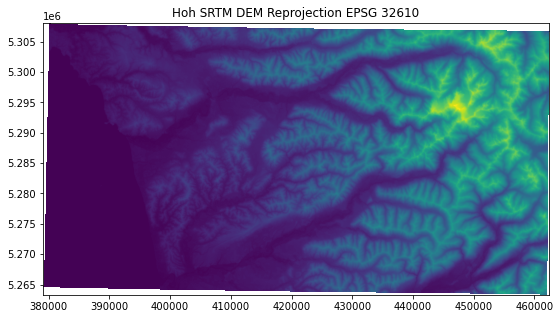

In [36]:
# reprojected EPSG 32610
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow(hoh_proj, extent = hoh_proj_extent)
ax.set(title="Hoh SRTM DEM Reprojection EPSG 32610")

# Find and grab shapefile for the Hoh to use for clipping

In [37]:
#For now...
hoh_shp_fn = '../gda_teal_carbon/hoh_watershed_outline/hoh_watershed_outline.shp'
hoh_shp = gpd.read_file(hoh_shp_fn)
hoh_geom = hoh_shp.geometry
type(hoh_geom)

geopandas.geoseries.GeoSeries

<AxesSubplot:>

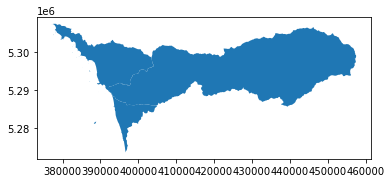

In [38]:
hoh_geom = hoh_geom.to_crs('EPSG:32610')
hoh_geom.plot()

-124.56738280411808 	  Ymin = 47.581065006875235 	  Xmax = -123.81207274552435 	  Ymax = 47.92637341837292# Need to merge SRTM DEMs together

In [39]:
hoh_src.res

(0.0002777777777778146, 0.0002777777777778146)

# Clip the DEMs and other rasters by the Hoh shapefile

In [40]:
hoh_clip, hoh_clip_trans = rio.mask.mask(hoh_proj_src, hoh_geom, filled = False, crop = True, indexes = 1)
hoh_clip_extent = rio.plot.plotting_extent(hoh_clip, hoh_clip_trans)


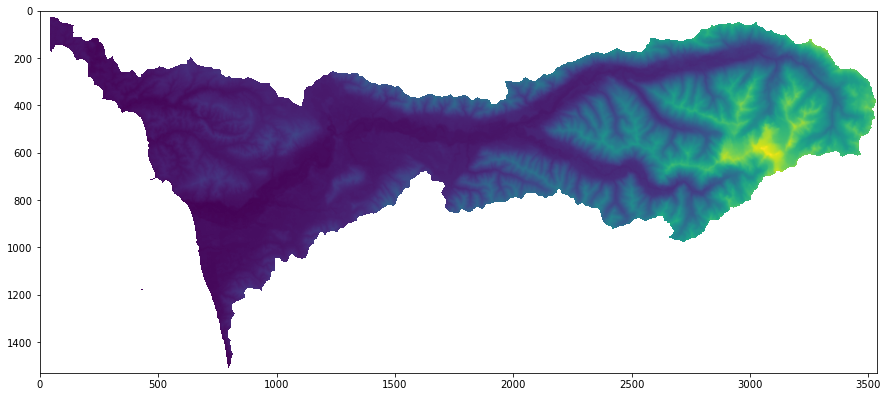

In [41]:
f,ax = plt.subplots(figsize = (15,10))
ax.imshow(hoh_clip)


In [42]:
hoh_shapes = features.shapes(hoh_clip)
hoh_shapes

<generator object shapes at 0x7fe5dc342510>

In [43]:
# hoh_clipped = hoh.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# cat_clipped = catarea.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# twi_clipped = twi.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)
# slp_clipped = slp.rio.clip(hoh_geom.geometry.apply(mapping),
#                                       # This is needed if your GDF is in a diff CRS than the raster data
#                                       hoh_geom.crs)

## Export raster for Hoh

In [44]:
data_path = '../gda_teal_carbon/raster_layers/'
hoh_clip_path = 'hoh_clip.tif'
hoh_clip_data_path = os.path.join(data_path, hoh_clip_path)
if os.path.exists(hoh_clip_data_path):
    print("The directory", hoh_clip_data_path, "exists!")
else:
    hoh_clipped.rio.to_raster(hoh_clip_data_path)

The directory ../gda_teal_carbon/raster_layers/hoh_clip.tif exists!


# This might be where ArcGIS is needed to generate DEM metrics (slope, catchment, curvature, etc.) and to get the model output

        ## whooo magic!


# Import raster outputs from ArcGIS 

## Reproject using GDAL

In [45]:
def replace_and_fill_nodata_value(array, nodata_value, fill_value):
    """
    Replace nodata values with fill value in array.
    Parameters
    ----------
    array : numpy.ndarray
    nodata_value : value similar to array.dtype
    fill_value : value similar to array.dtype
    Returns
    -------
    masked_array : numpy.ndarray
    """
    if np.isnan(nodata_value):
        masked_array = np.nan_to_num(array, nan=fill_value)
    else:
        mask = array == nodata_value
        masked_array = np.ma.masked_array(array, mask=mask)
        masked_array = np.ma.filled(masked_array, fill_value=fill_value)

    return masked_array

In [46]:
wip_fn = '../gda_teal_carbon/raster_layers/hoh_WIP.tif'
wip_proj_fn = os.path.splitext(wip_fn)[0] + '__utmzn10_gdalwarp.tif'
if not os.path.exists(wip_proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $wip_fn $wip_proj_fn

In [47]:
# Define source with rio open to make masked array from file
wip_src = rio.open(wip_proj_fn, masked=True)
# Clip the masked array with rio.mask.mask and the hoh_geom shapefile
wip_clip, wip_clip_trans = rio.mask.mask(wip_src, hoh_geom, filled = False, crop = True, indexes = 1)
#wip = wip_src.read(1, masked = True)
#Fill the no data values from the function that Friedrich sent
wip_fill = replace_and_fill_nodata_value(wip_clip, wip_src.nodata, np.nan)
# subtract the values from 1 because probability scale is flipped 
wip_fill = 1-wip_fill
#wip = rxr.open_rasterio(wip_fn, masked=True).squeeze()
wip_fill

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [86]:
wip_src.profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4e+38, 'width': 2171, 'height': 1604, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(37.62146166359818, 0.0, 375905.1041983579,
       0.0, -37.62146166359818, 5307611.062488408), 'tiled': False, 'interleave': 'band'}

In [48]:
slp_fn = '../gda_teal_carbon/raster_layers/rclip_TWISlope.tif'
slp_proj_fn = os.path.splitext(slp_fn)[0] + '__utmzn10_gdalwarp.tif'
if not os.path.exists(slp_proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $slp_fn $slp_proj_fn

In [49]:
slp_src = rio.open(slp_proj_fn, masked=True)
slp_clip, slp_clip_trans = rio.mask.mask(slp_src, hoh_geom, filled = False, crop = True, indexes = 1)
#slp = slp_src.read(1, masked = True)
slp_fill = replace_and_fill_nodata_value(slp_clip, slp_src.nodata, np.nan)
#slp = rxr.open_rasterio(slp_fn, masked=True).squeeze()
slp_fill

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [50]:
twi_fn = '../gda_teal_carbon/raster_layers/rclip_TWI.tif'
twi_proj_fn = os.path.splitext(twi_fn)[0] + '__utmzn10_gdalwarp.tif'
if not os.path.exists(twi_proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $twi_fn $twi_proj_fn

In [51]:
twi_src = rio.open(twi_proj_fn)
twi_clip, twi_clip_trans = rio.mask.mask(twi_src, hoh_geom, filled = False, crop = True, indexes = 1)

#twi = twi_src.read(1, masked = True)
twi_fill = replace_and_fill_nodata_value(twi_clip, twi_src.nodata, np.nan)
#twi = rxr.open_rasterio(twi_fn, masked=True).squeeze()
twi_fill

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [52]:
catarea_fn = '../gda_teal_carbon/raster_layers/rclip_SCatA.tif'
catarea_proj_fn = os.path.splitext(catarea_fn)[0] + '__utmzn10_gdalwarp.tif'
if not os.path.exists(catarea_proj_fn):
    !gdalwarp -r cubic -t_srs $dst_crs $catarea_fn $catarea_proj_fn

In [53]:
catarea_src = rio.open(catarea_proj_fn)
cat_clip, cat_clip_trans = rio.mask.mask(catarea_src, hoh_geom, filled = False, crop = True, indexes = 1)
#catarea = catarea_src.read(1, masked = True)

catarea_fill = replace_and_fill_nodata_value(cat_clip, catarea_src.nodata, np.nan)
# lots of weird negative values 
catarea_fill[np.where(catarea_fill <=0)] =0
#catarea = rxr.open_rasterio(catarea_fn, masked=True).squeeze()
np.nanmin(catarea_fill)

0.0

# Clip extra extent off watershed area 

### Extract a portion of the DEM around Mt Rainier

In [54]:
hoh_proj_src.bounds

BoundingBox(left=379038.09011716006, bottom=5263307.094857047, right=462451.1528539235, top=5308086.972644434)

In [55]:
#From Raster1 lab
window_bounds = (379038.09011716006, 5263307.094857047, 462451.1528539235, 5308086.972644434)
print("Window bounds: ", window_bounds)
window_extent = [window_bounds[0], window_bounds[2], window_bounds[1], window_bounds[3]]
print("Window extent: ", window_extent)

Window bounds:  (379038.09011716006, 5263307.094857047, 462451.1528539235, 5308086.972644434)
Window extent:  [379038.09011716006, 462451.1528539235, 5263307.094857047, 5308086.972644434]


In [56]:
hoh_window = rio.windows.from_bounds(*window_bounds, transform=hoh_proj_src.transform)
hoh_window

Window(col_off=0.0, row_off=0.0, width=3759.0, height=2018.0)

In [57]:
wip_ma = hoh_proj_src.read(1, window=hoh_window)
#rainier_ma = np.ma.masked_equal(rainier_ma, src_proj.nodata)

[Text(0.5, 1.0, 'Wetland Probability in Hoh River Watershed')]

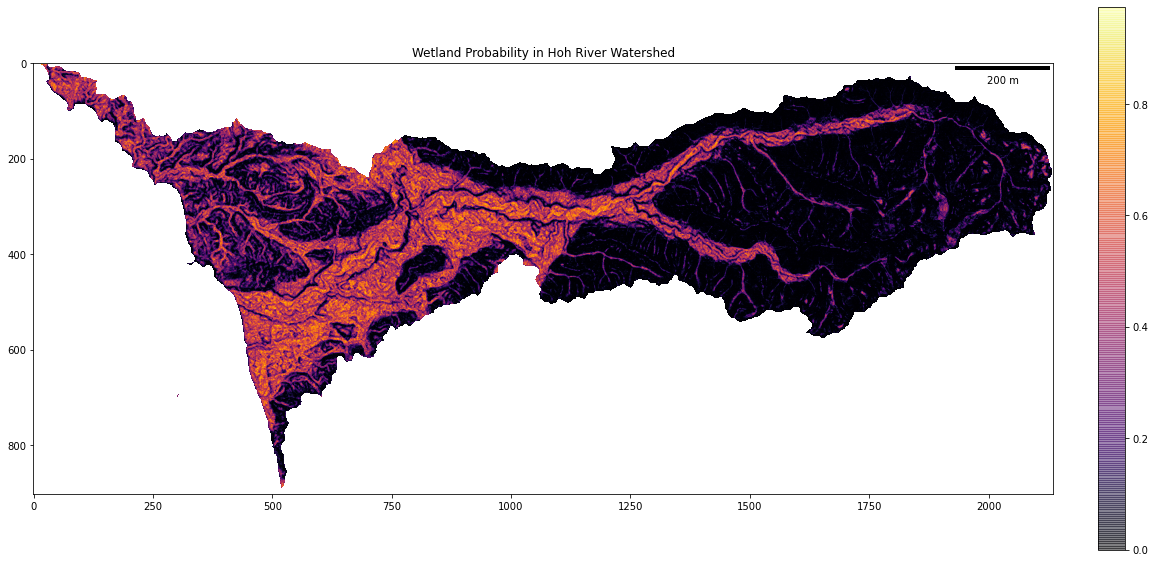

In [58]:
from matplotlib_scalebar.scalebar import ScaleBar
f, ax = plt.subplots(figsize = (20, 10))
ax.imshow((1- wip_clip), cmap = 'inferno')
ax.add_artist(ScaleBar(1.0))
m = ax.imshow((1-wip_clip),  alpha=0.5, cmap = 'inferno')
f.colorbar(m, fraction=0.046, pad=0.04, ax = ax)


ax.set(title="Wetland Probability in Hoh River Watershed")


# Import the point data for the Carbon Stocks

In [59]:
hohpts_fn = '../gda_teal_carbon/hoh_sample_datasheet_2020.csv'
hohpts_df = pd.read_csv(hohpts_fn)
#import with the original EPSG:4326 crs because coordinate need to be reprojected into EPSG: 32610
hohpts_gdf = gpd.GeoDataFrame(hohpts_df, crs='EPSG:4326', geometry=gpd.points_from_xy(hohpts_df['lon'], hohpts_df['lat']))
hoh_pts = hohpts_gdf.to_crs('EPSG:32610')
#hohpts_geo = gpd.read_file(hohpts_fn)
hoh_pts

,sample name,c_stock_g_cm2,full_horiz_c_stock,WIP,w_or_u,lat,lon,geometry
0,W Hoh Oxbow,0.057251,0.928835,0.855,w,47.810750,-124.260700,POINT (405614.756 5296035.660)
1,E-ML-FR-H-1040,0.530333,6.987945,0.075,w,47.778390,-124.116967,POINT (416323.580 5292273.720)
2,Hoh-ML-FR-1008.1,0.918214,4.041169,0.105,u,47.797501,-124.188779,POINT (410976.575 5294477.878)
3,Hoh-ML-NE-FR-1043,2.967889,7.803837,0.270,w,47.787200,-124.110355,POINT (416832.959 5293245.729)
4,S-Hoh-ML-FR-1200,0.645896,1.289509,0.365,u,47.789367,-124.166635,POINT (412621.201 5293548.616)
5,N-Up-Hoh-MC,0.110212,1.767975,0.755,u,47.821061,-124.042698,POINT (421951.246 5296938.521)
6,N-Mid-Hoh-MC,0.034643,1.191331,0.010,w,47.813808,-124.129756,POINT (415423.020 5296223.982)


# Extract data from the around the point data 
* Look at Friedrich's links in Slack
* Try different methods of extraction (Nearest Neighbor, etc.)

Overlay points on top of raster

<AxesSubplot:>

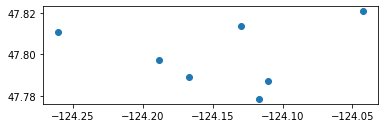

In [60]:
f, ax = plt.subplots()
hohpts_gdf.plot(ax =ax)


In [61]:
coord_list =[(x,y) for x,y in zip(hoh_pts.geometry.x , hoh_pts.geometry.y)]

wip_sample = rio.sample.sample_gen(wip_src, coord_list)
wip_sample_wrap = np.fromiter(wip_sample, float)

catarea_sample = rio.sample.sample_gen(catarea_src, coord_list)
catarea_sample_wrap = np.fromiter(catarea_sample, float)

twi_sample = rio.sample.sample_gen(twi_src, coord_list)
twi_sample_wrap = np.fromiter(twi_sample, float)

slp_sample = rio.sample.sample_gen(slp_src, coord_list)
slp_sample_wrap = np.fromiter(slp_sample, float)

In [62]:
slp_sample_wrap

array([0.26424015, 0.03256953, 0.03418323, 0.05917584, 0.06646031,
       0.1173952 , 0.07150006])

In [63]:
1-wip_sample_wrap

array([0.19482189, 0.6895906 , 0.61018321, 0.45984983, 0.68468887,
       0.48000699, 0.32479042])

In [64]:
#hoh_pts.drop(['wip_smpl'], axis = 1)
hoh_pts['wip_smpl'] = 1- wip_sample_wrap
hoh_pts['catarea_smpl'] = catarea_sample_wrap
hoh_pts['twi_smpl'] = twi_sample_wrap
hoh_pts['slp_smpl'] = slp_sample_wrap

In [65]:
hoh_pts

,sample name,c_stock_g_cm2,full_horiz_c_stock,WIP,w_or_u,lat,lon,geometry,wip_smpl,catarea_smpl,twi_smpl,slp_smpl
0,W Hoh Oxbow,0.057251,0.928835,0.855,w,47.810750,-124.260700,POINT (405614.756 5296035.660),0.194822,76.565704,5.684350,0.264240
1,E-ML-FR-H-1040,0.530333,6.987945,0.075,w,47.778390,-124.116967,POINT (416323.580 5292273.720),0.689591,821.829773,10.137813,0.032570
2,Hoh-ML-FR-1008.1,0.918214,4.041169,0.105,u,47.797501,-124.188779,POINT (410976.575 5294477.878),0.610183,639.383606,9.836663,0.034183
3,Hoh-ML-NE-FR-1043,2.967889,7.803837,0.270,w,47.787200,-124.110355,POINT (416832.959 5293245.729),0.459850,128.620682,7.684139,0.059176
4,S-Hoh-ML-FR-1200,0.645896,1.289509,0.365,u,47.789367,-124.166635,POINT (412621.201 5293548.616),0.684689,59.740406,6.801443,0.066460
5,N-Up-Hoh-MC,0.110212,1.767975,0.755,u,47.821061,-124.042698,POINT (421951.246 5296938.521),0.480007,425.636475,8.196053,0.117395
6,N-Mid-Hoh-MC,0.034643,1.191331,0.010,w,47.813808,-124.129756,POINT (415423.020 5296223.982),0.324790,37.624371,6.265184,0.071500


# Regression between carbon values and raster values

In [66]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(hoh_pts['full_horiz_c_stock'] , hoh_pts['wip_smpl'])

In [67]:
print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 0.4001
B1 : 0.0268
R^2 : 0.175
R : 0.419
stderr : 0.026


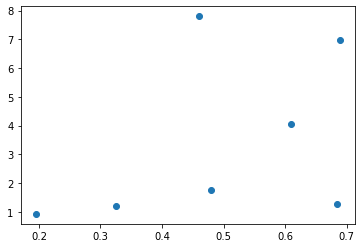

In [68]:
f, ax = plt.subplots()

ax.scatter(hoh_pts['wip_smpl'], hoh_pts['full_horiz_c_stock'])

In [69]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(hoh_pts['full_horiz_c_stock'] , hoh_pts['catarea_smpl'])

In [70]:
print('B0 : {}'.format(np.round(intercept,4)))
print('B1 : {}'.format(np.round(slope,4)))
print('R^2 : {}'.format(np.round(rvalue**2,3)))
print('R : {}'.format(np.round(rvalue,3)))
print('stderr : {}'.format(np.round(stderr,3)))

B0 : 125.9033
B1 : 54.4792
R^2 : 0.248
R : 0.498
stderr : 42.441


## First MLR All Variables

In [72]:
multi_input = np.array([hoh_pts['wip_smpl'], hoh_pts['catarea_smpl'], 
                        hoh_pts['twi_smpl'], hoh_pts['slp_smpl'], np.ones_like(hoh_pts['wip_smpl'])]).T
B, _, _, _ = lstsq(multi_input, hoh_pts['full_horiz_c_stock'])
print('wip, catarea, twi, slp = {}'.format(np.round(B, 3)))

wip, catarea, twi, slp = [-5.6060e+00 -1.5000e-02  4.2390e+00  4.3230e+00 -2.2714e+01]


In [98]:
wip_clip.count()

692952

In [100]:
total_sqm = np.sum(wip_clip.count()*wip_src.res[0]**2)

In [101]:
MLR = B[0]*wip_fill + B[1]*catarea_fill + B[2]*twi_fill + B[3]*slp_fill + B[4]
np.nansum(MLR[MLR>0])/total_sqm

0.0010707132681898111

## Second MLR removing Catchment Area

In [75]:
multi_input = np.array([hoh_pts['wip_smpl'], 
                        hoh_pts['twi_smpl'], hoh_pts['slp_smpl'], np.ones_like(hoh_pts['wip_smpl'])]).T
A, _, _, _ = lstsq(multi_input, hoh_pts['full_horiz_c_stock'])
print('wip, twi, slp, intercept= {}'.format(np.round(A, 3)))

wip, twi, slp, intercept= [ -5.609   1.098 -14.093  -1.072]


In [103]:
MLR2 = A[0]*wip_fill + A[1]*twi_fill + A[2]*slp_fill + A[3]
np.nansum(MLR2[MLR2>0])#/total_sqm

1174664.0

## Third MLR removing WIP 

In [77]:
multi_input = np.array([hoh_pts['catarea_smpl'], 
                        hoh_pts['twi_smpl'], hoh_pts['slp_smpl'], np.ones_like(hoh_pts['wip_smpl'])]).T
C, _, _, _ = lstsq(multi_input, hoh_pts['full_horiz_c_stock'])
print('wip, twi, slp, intercept= {}'.format(np.round(C, 3)))

wip, twi, slp, intercept= [-1.5000e-02  4.0090e+00  1.1145e+01 -2.4305e+01]


In [104]:
MLR3 = C[0]*catarea_fill + C[1]*twi_fill + C[2]*slp_fill + C[3]
np.nansum(MLR3[MLR3>0])

1298193.8

In [79]:
%matplotlib inline

[Text(0.5, 1.0, 'MLR All Variables Continuous Carbon Stocks kg/m2')]

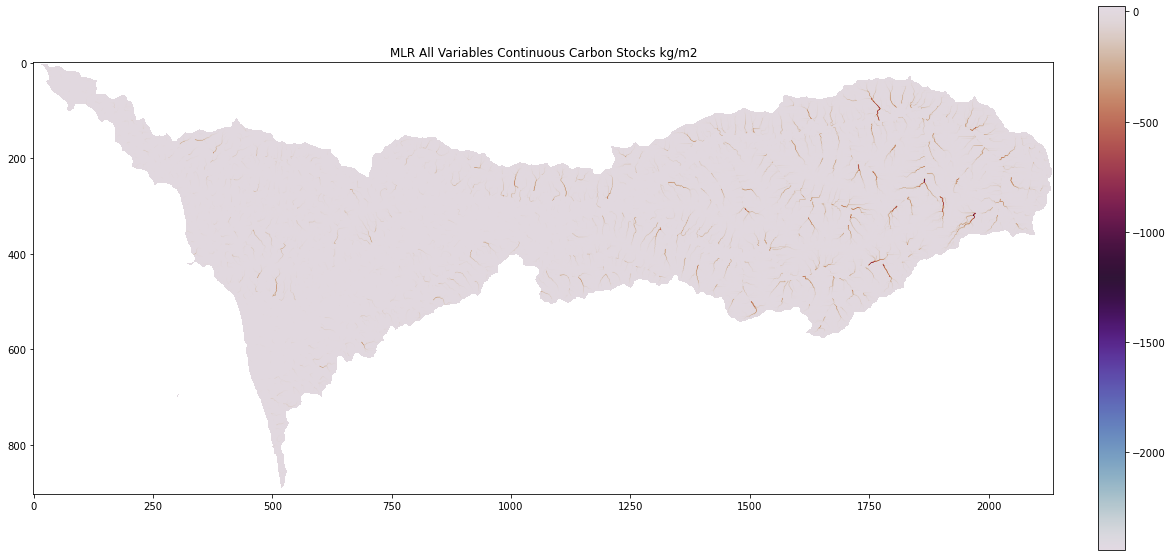

In [110]:
f, ax = plt.subplots(figsize = (20, 10))
plt.imshow(MLR,  cmap = 'twilight')
plt.colorbar(fraction=0.046, pad=0.04)
ax.set(title="MLR All Variables Continuous Carbon Stocks kg/m2")

[Text(0.5, 1.0, 'MLR All Variables with vmin = 0 Continuous Carbon Stocks kg/m2')]

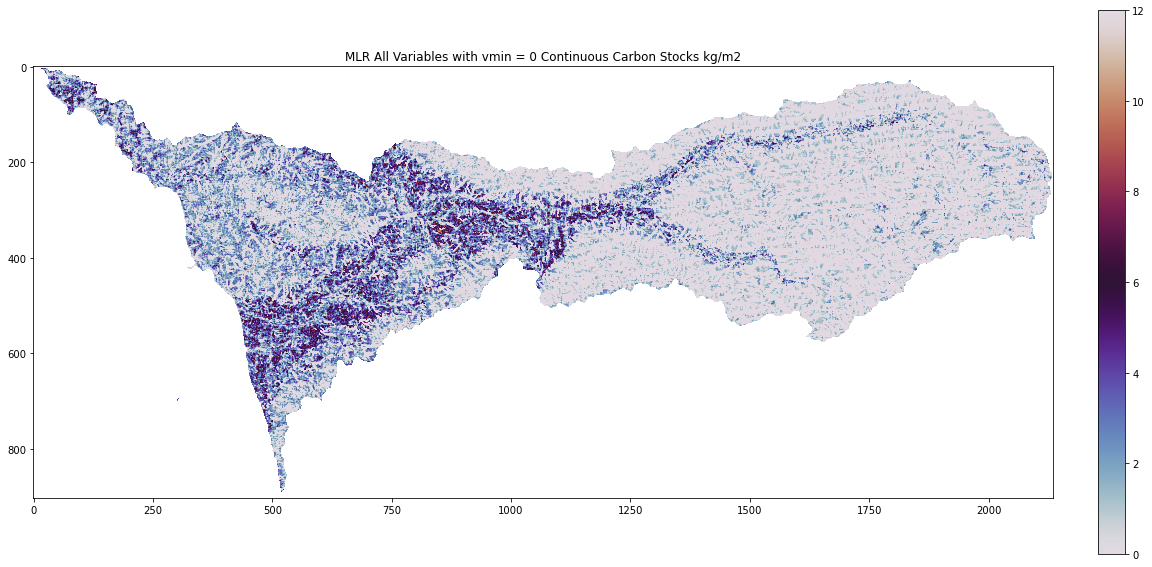

In [113]:
f, ax = plt.subplots(figsize = (20, 10))
plt.imshow(MLR, vmin = 0, vmax = 12, cmap = 'twilight')
plt.colorbar(fraction=0.046, pad=0.04)

ax.set(title="MLR All Variables with vmin = 0 Continuous Carbon Stocks kg/m2")

[Text(0.5, 1.0, 'MLR 2 No CatArea Continuous Carbon Stocks kg/m2')]

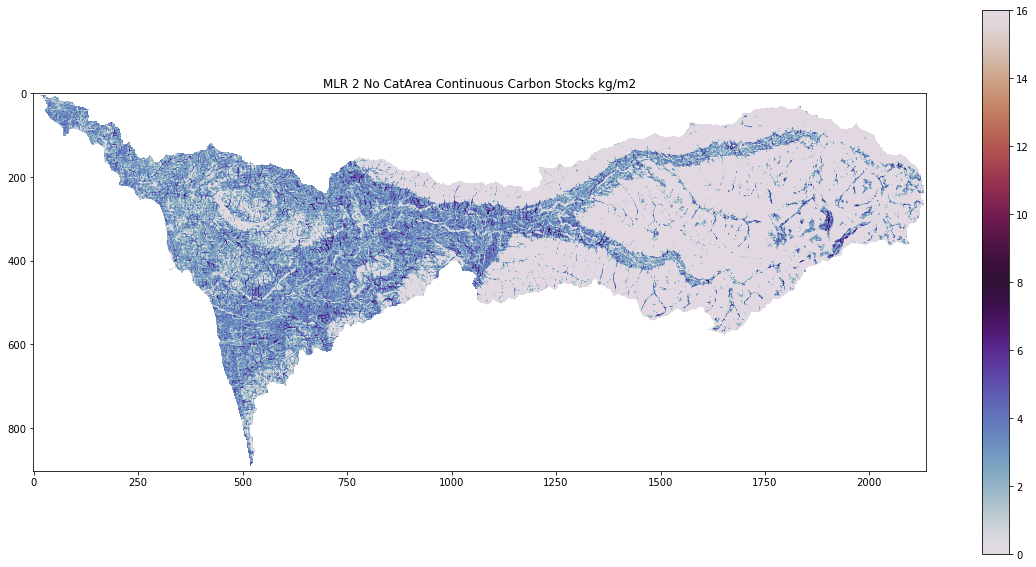

In [111]:
f, ax = plt.subplots(figsize = (20, 10))
plt.imshow(MLR2, vmin =0,  cmap = 'twilight')
plt.colorbar()

ax.set(title="MLR 2 No CatArea Continuous Carbon Stocks kg/m2")

[Text(0.5, 1.0, 'MLR No WIP Continuous Carbon Stocks kg/m2')]

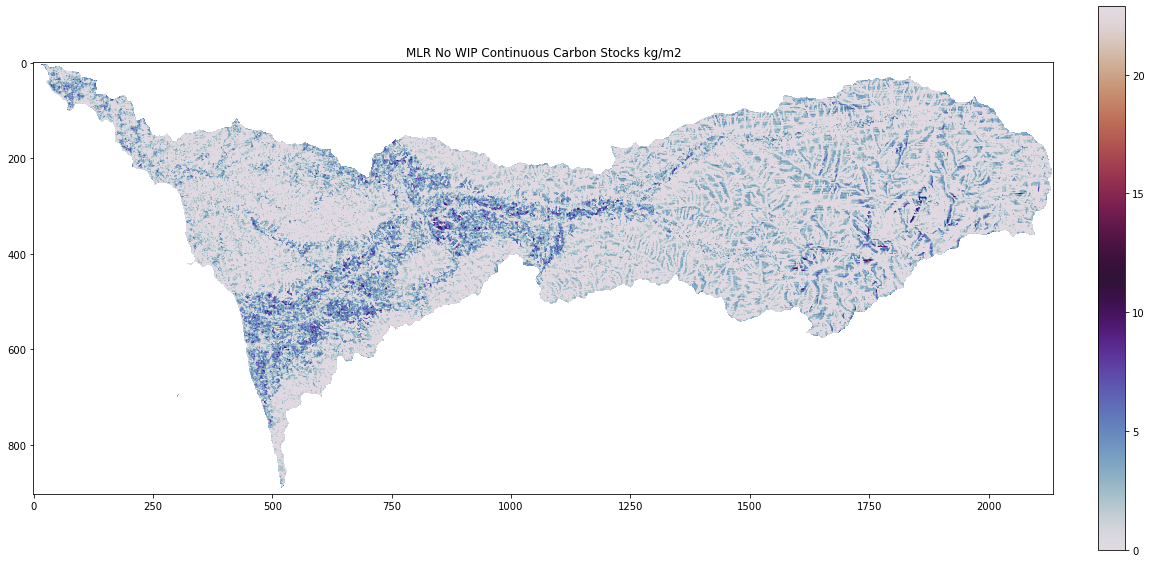

In [112]:
f, ax = plt.subplots(figsize = (20, 10))
plt.imshow(MLR3, vmin =0,  cmap = 'twilight')
plt.colorbar(fraction=0.046, pad=0.04)

ax.set(title="MLR No WIP Continuous Carbon Stocks kg/m2")